In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
from typing import Self
from datetime import datetime
from functools import reduce
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from concurrent.futures import ThreadPoolExecutor, wait, FIRST_COMPLETED

import src.utils.anomalydetectors as m
import src.utils.globals as g
import src.utils.aggregators as agg

from src.utils.noise import NoiseFactory
from src.utils.plotting import plot_rpcurves
from src.utils.experiment import Experiment


In [24]:
def run_experiment(df : pd.DataFrame, models, columns, name, synanomalies=True):
    if synanomalies:
        df['anomalous'] = df['anomaly_syn_type'] != ""
    else:
        df['anomalous'] = df['anomaly'] != "none"


    df_anomalies = df.groupby('seqid').agg({'anomalous' : any})

    experiment = Experiment(name)
    experiment.run(df, models, (['seqid', 'timeindex_bin'], columns), verbose=True)
    experiment.set_input(df)
    experiment.set_anomalies(df_anomalies)
    experiment.calculate_metrics(models=models, aggrfunc=agg.aggr_sum)

    experiment.pickle()

    return experiment

def name_none_experiment(sensor):
    return f"{sensor}_nonoise"

def name_gaussian_experiment(ratio, intensity, sensor):
    return f"{sensor}_gaussian_{ratio}_{intensity}"

def name_sinusoidal_experiment(ratio, intensity, sensor):
    return f"{sensor}_sinus_{ratio}_{intensity}"

def name_point_experiment(ratio, intensity, sensor):
    return f"{sensor}_point_{ratio}_{intensity}"

def run_gaussian_experiment(df : pd.DataFrame, models, exp_columns, syn_column, ratio, intensity):
    name = name_gaussian_experiment(ratio, intensity, syn_column)
    df_syn = NoiseFactory.gaussian(df, syn_column, ratio, intensity)
    return run_experiment(df_syn, models, exp_columns, name)

def run_sinusoidal_experiment(df : pd.DataFrame, models, exp_columns, syn_column, ratio, intensity):
    name = name_sinusoidal_experiment(ratio, intensity, syn_column)
    df_syn = NoiseFactory.sinusoidal(df, syn_column, ratio, intensity)
    return run_experiment(df_syn, models, exp_columns, name)

def run_point_experiment(df : pd.DataFrame, models, exp_columns, syn_column, ratio, intensity):
    name = name_point_experiment(ratio, intensity, syn_column)
    df_syn = NoiseFactory.point(df, syn_column, ratio, intensity)
    return run_experiment(df_syn, models, exp_columns, name)

def run_none_experiment(df : pd.DataFrame, models, sensor):
    name = name_none_experiment(sensor)
    return run_experiment(df, models, [f'{sensor}_{x}' for x in ['x', 'y', 'z']], name, synanomalies=False)


In [4]:
df_in = pd.read_parquet(g.path_imu)

# Experiment Constants

In [5]:
# Boolean whether to run the experiments or load
load_experiments = False

# Running Experiment Parameters
models = [m.ZScore(), m.MZScore(), m.LOF(), m.IF()]

guassian_params     = [0.10, 0.25, 0.40, 0.55]
sinusoidal_params   = [0.25, 0.5, 1, 2]
point_params        = [1, 5, 10, 100]

synratio = 0.1

# Loading Experiment Parameters



# GAUSSIAN

In [6]:
def run_experiments(params, name_func, run_func, exp_dict, sensor):
    exp_columns = [f'{sensor}_{x}' for x in ['x', 'y', 'z']]
    syn_column = f'{sensor}_x'  

    if load_experiments:
        for intensity in params:
            name = name_func(synratio, intensity)
            print(f"Loading {name}")
            exp_dict[name] = Experiment.unpickle(name)
        print("Loading Experiments Done")
    else:
        for intensity in params:
            print(f"Running Experiment {name_func.__name__.split('_')[1].capitalize()} {intensity}")
            exp = run_func(df_in, models, exp_columns, exp_columns[0], ratio=synratio, intensity=intensity)
            exp_dict[exp.name] = exp
        print("Running Experiments Done")
        


In [ ]:
for sensor in ['gyroscope', 'magnetic']:
    run_experiments(guassian_params, name_gaussian_experiment, run_gaussian_experiment, {}, sensor=sensor)
    run_experiments(sinusoidal_params, name_sinusoidal_experiment, run_sinusoidal_experiment, {}, sensor=sensor)
    run_experiments(point_params, name_point_experiment, run_point_experiment, {}, sensor=sensor)          

Loading acceleration_x_gaussian_0.1_0.25
Loading gyroscope_x_gaussian_0.1_0.25
Loading magnetic_x_gaussian_0.1_0.25
Loading Experiments Done


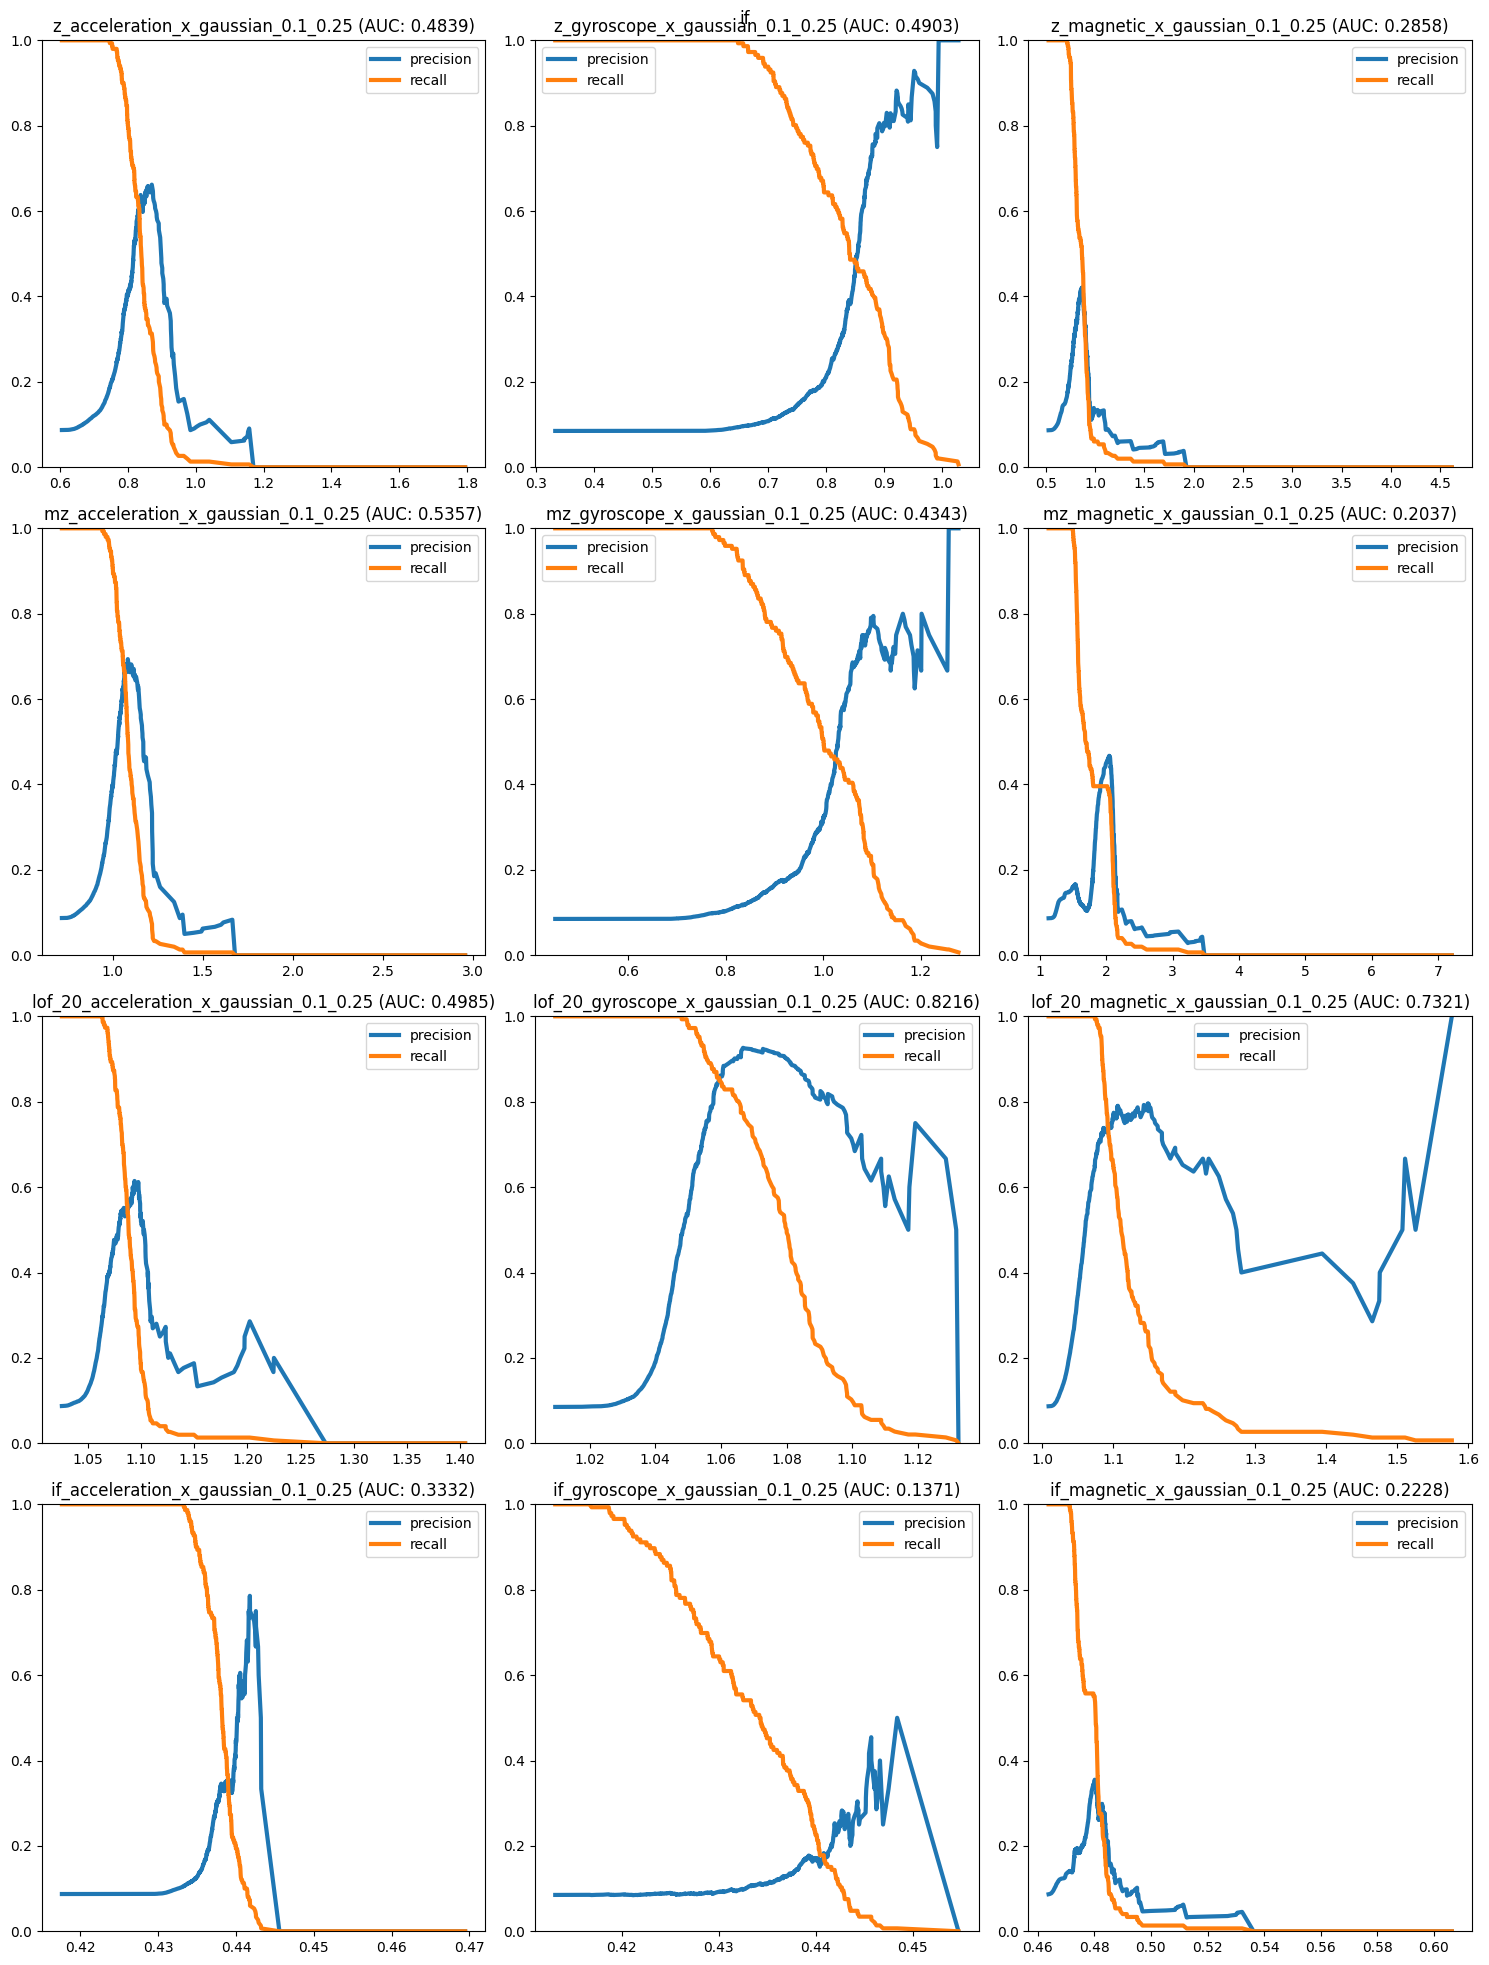

In [17]:
def exp_load_and_plot(exps_params):
    exps = {}
    for name_func, sensor, synratio, intensity in exps_params:
        name = name_func(synratio, intensity, sensor)
        print(f"Loading {name}")
        exps[name] = Experiment.unpickle(name)
    print("Loading Experiments Done")

    rp_curves = {}
    for exp in models:
        mname = exp.name
        for (ename, exp) in exps.items():
            rp_curves[f"{mname}_{ename}"] = exp.results['pr'][mname]


    with warnings.catch_warnings(action="ignore"):
        plot_rpcurves(rp_curves, colnums=3, title=mname, auc=True, f1=False, showtitle=True)

exp_load_and_plot([(name_gaussian_experiment, "acceleration_x", 0.1, 0.25), 
                   (name_gaussian_experiment, "gyroscope_x", 0.1, 0.25), 
                   (name_gaussian_experiment, "magnetic_x", 0.1, 0.25)])

Loading acceleration_x_sinus_0.1_1
Loading gyroscope_x_sinus_0.1_1
Loading magnetic_x_sinus_0.1_1
Loading Experiments Done


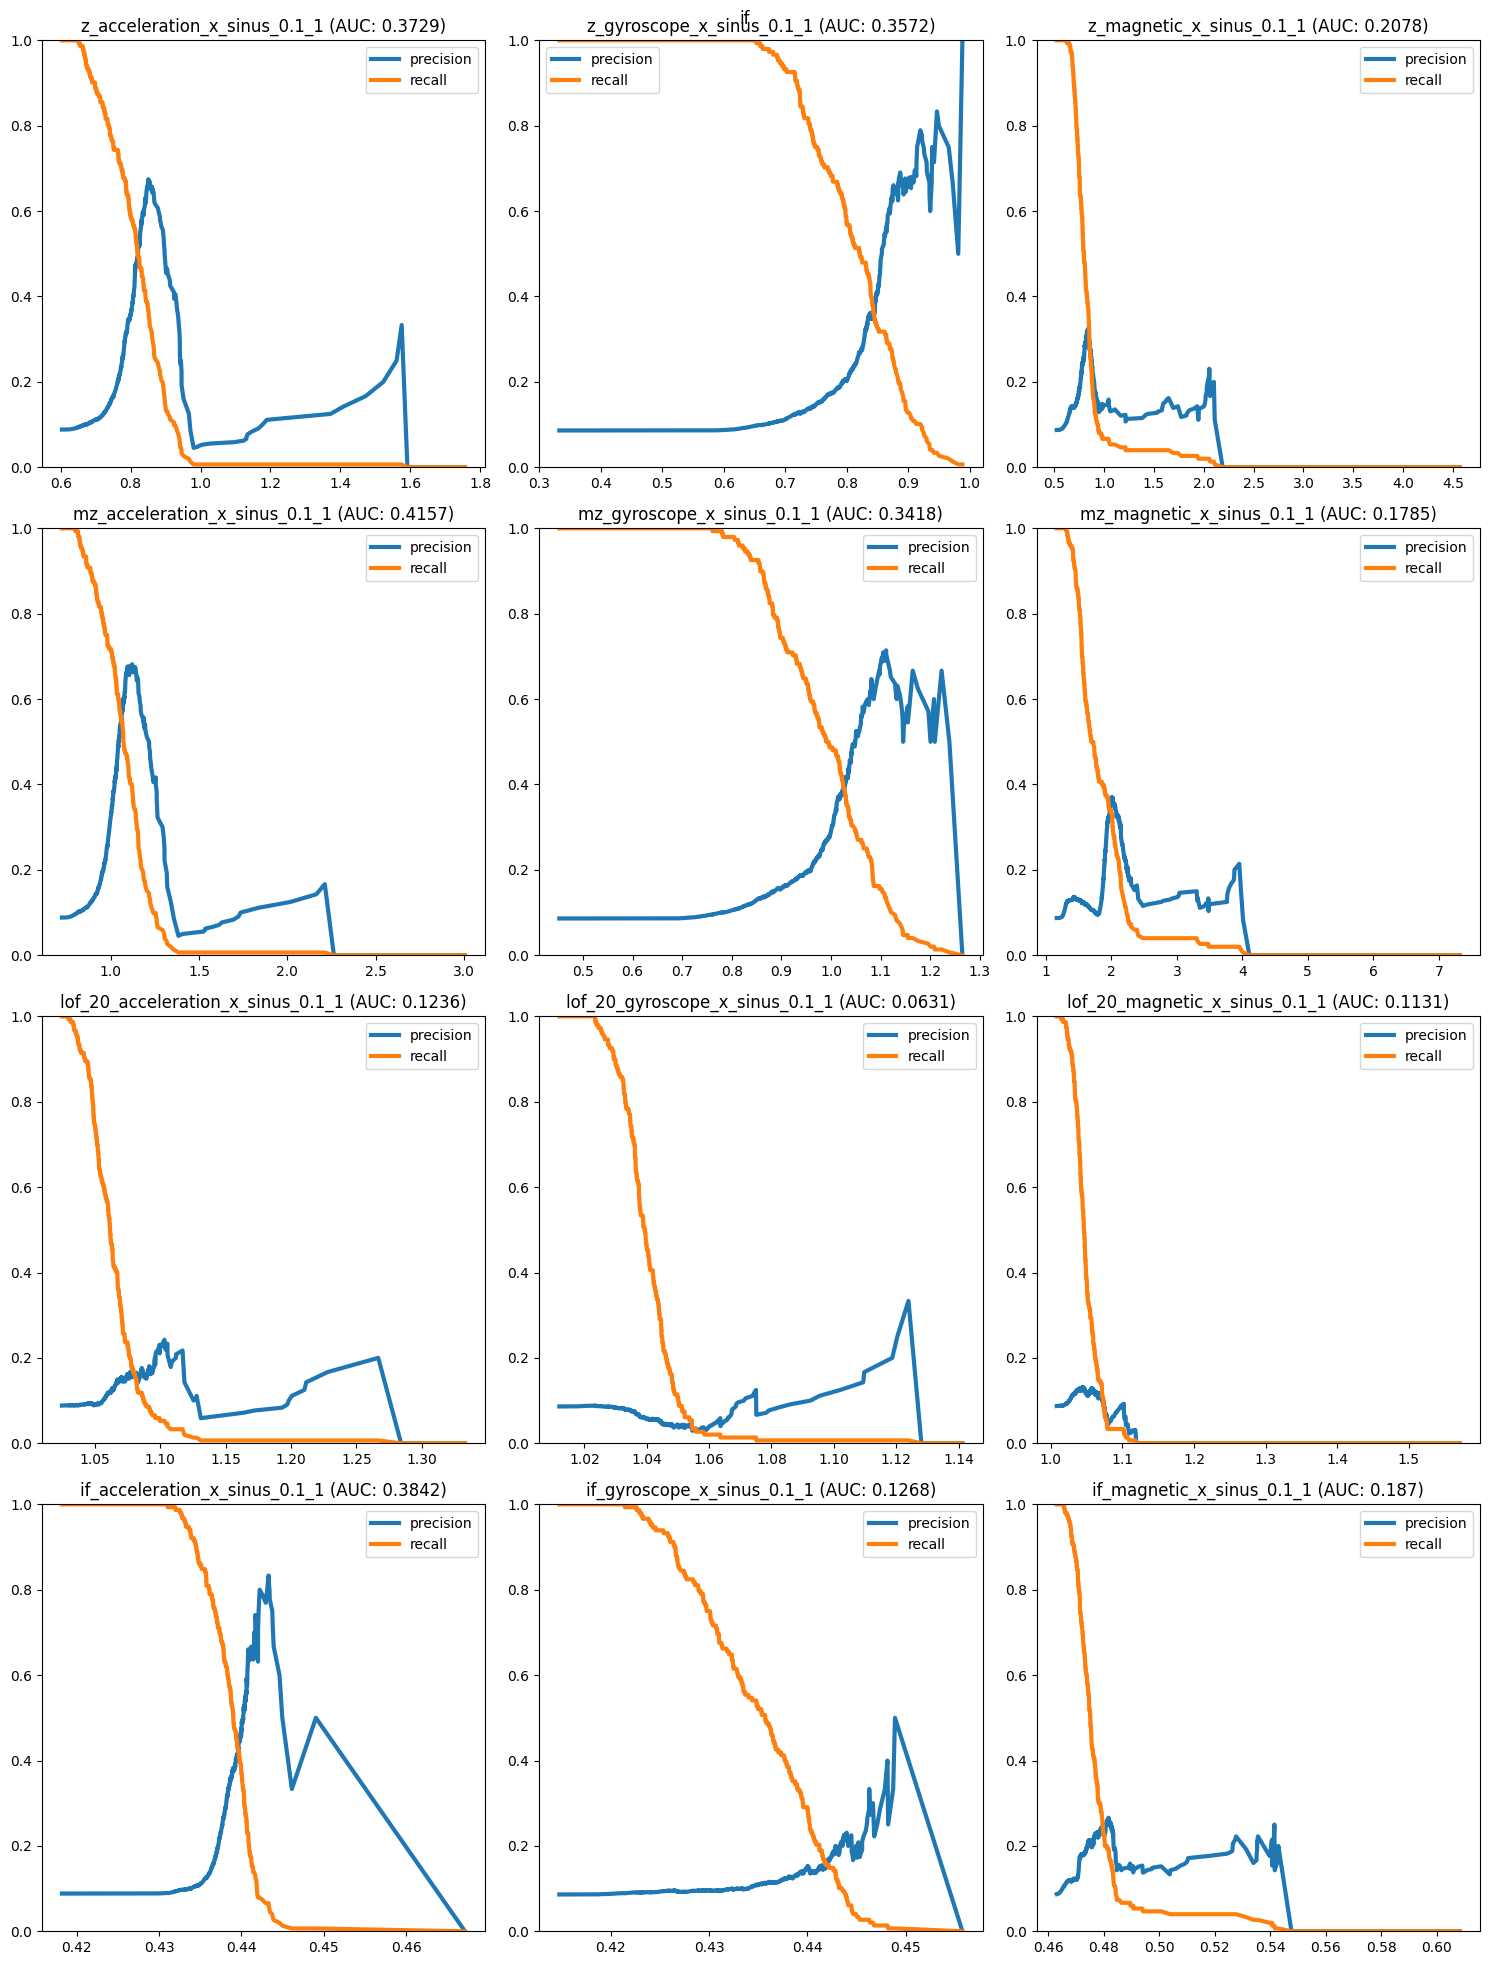

In [19]:
exp_load_and_plot([(name_sinusoidal_experiment, "acceleration_x", 0.1, 1), 
                   (name_sinusoidal_experiment, "gyroscope_x", 0.1, 1), 
                   (name_sinusoidal_experiment, "magnetic_x", 0.1, 1)])


Loading acceleration_x_point_0.1_10
Loading gyroscope_x_point_0.1_10
Loading magnetic_x_point_0.1_10
Loading Experiments Done


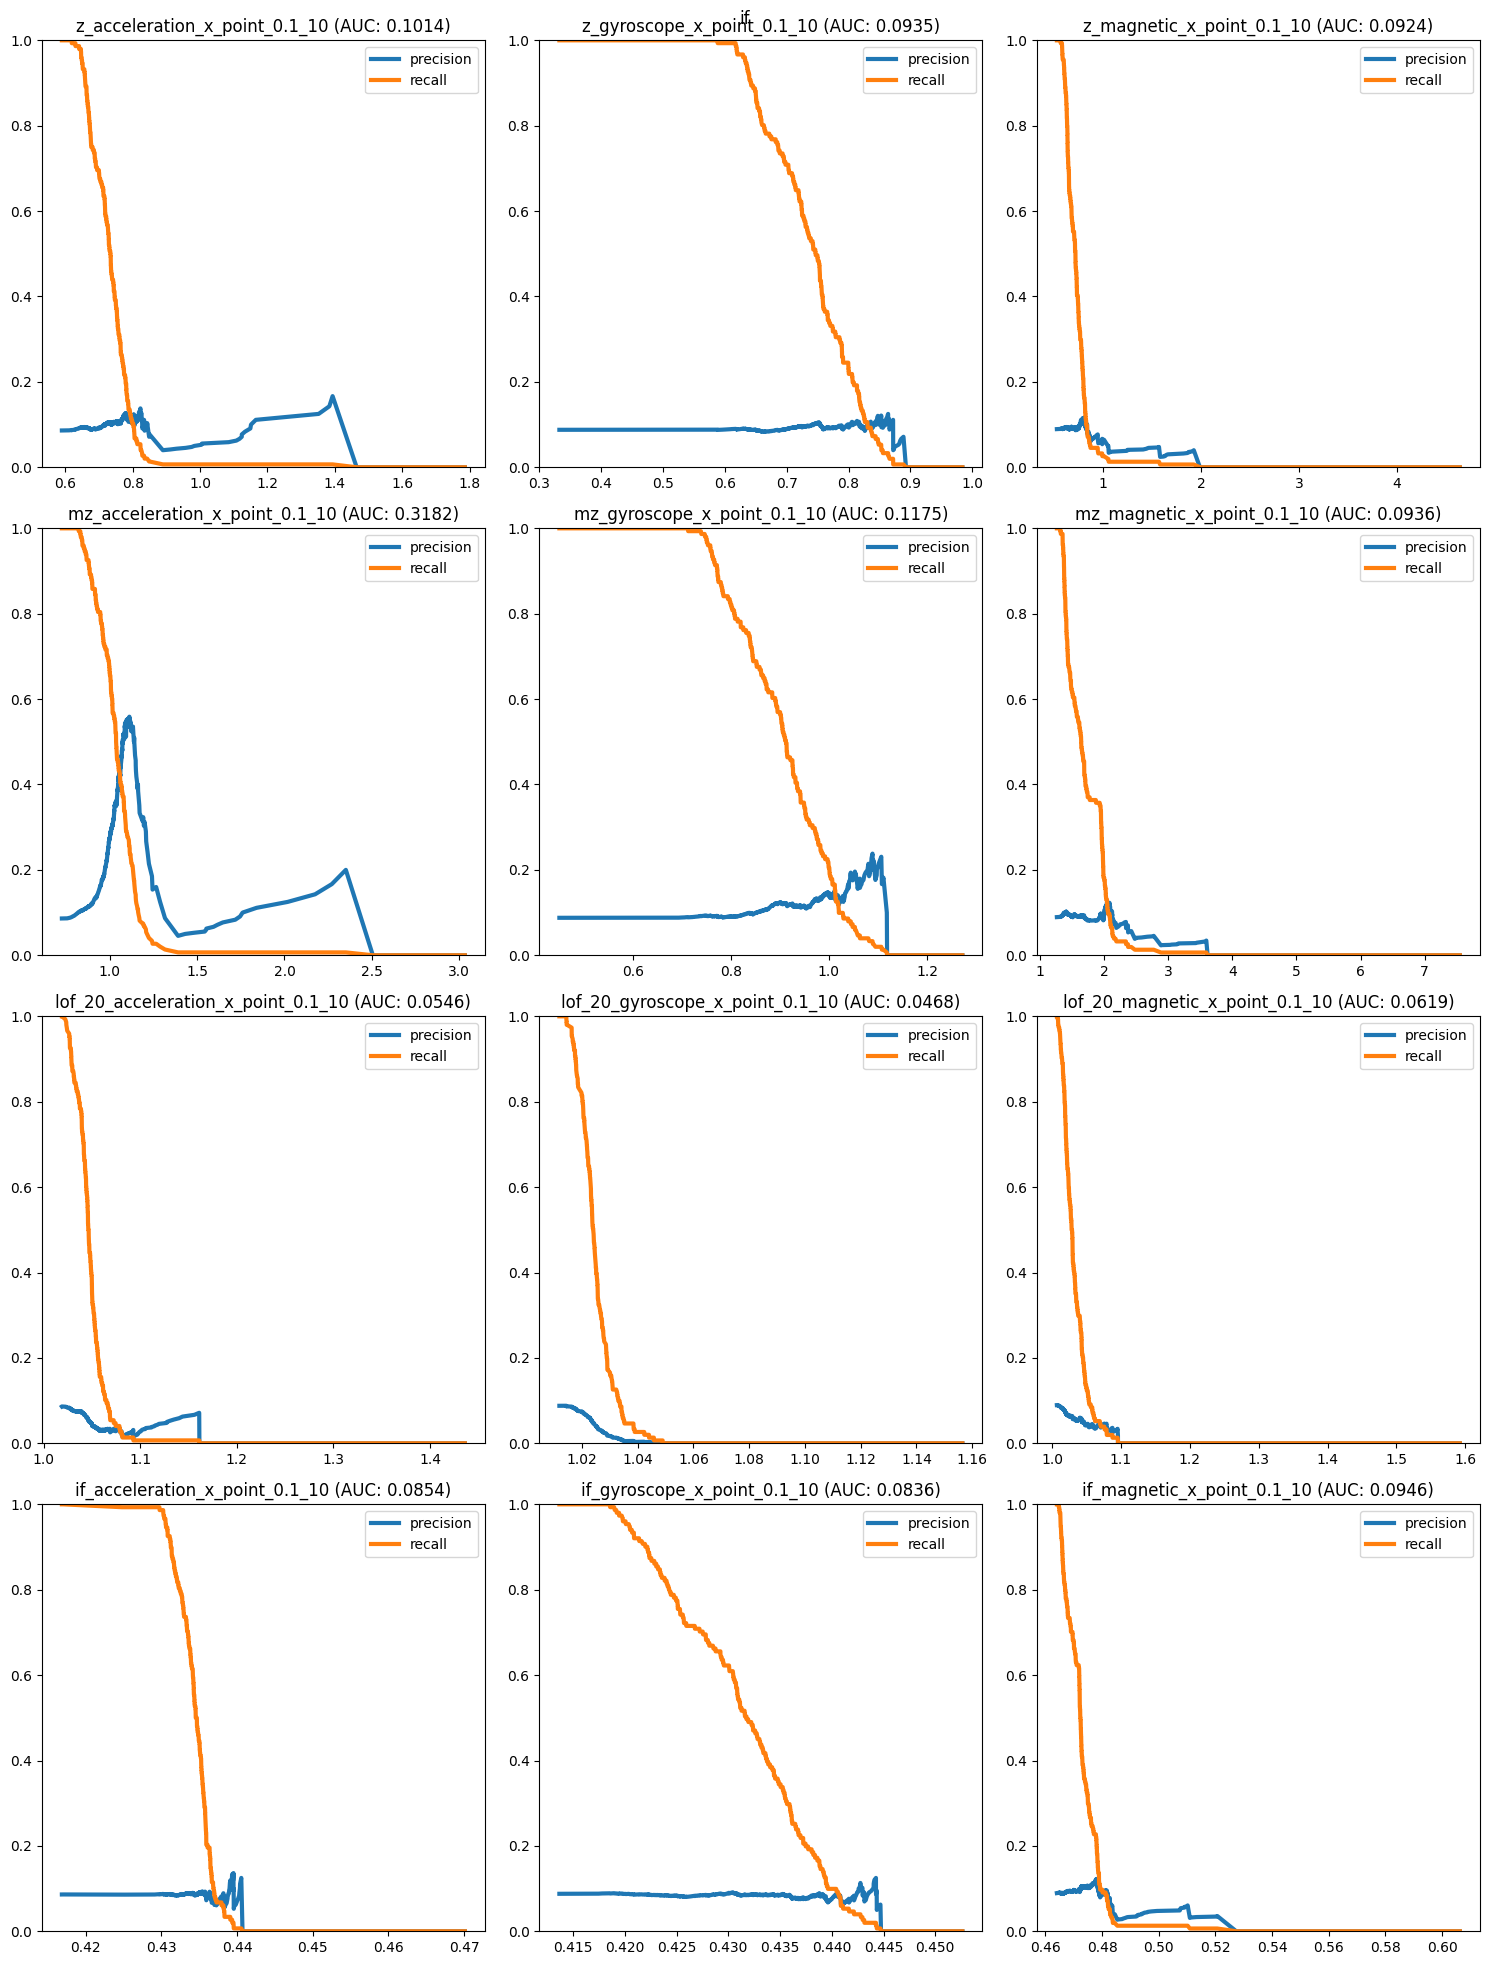

In [21]:
exp_load_and_plot([(name_point_experiment, "acceleration_x", 0.1, 10), 
                   (name_point_experiment, "gyroscope_x", 0.1, 10), 
                   (name_point_experiment, "magnetic_x", 0.1, 10)])

In [ ]:
exp_load_and_plot([(name_point_experiment, "acceleration_x", 0.1, 10), 
                   (name_point_experiment, "gyroscope_x", 0.1, 10), 
                   (name_point_experiment, "magnetic_x", 0.1, 10)])

In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    rp_curves[mname] = {}
    for (ename, exp) in exps_gaussian.items():
        rp_curves[mname][ename] = exp.results['pr'][mname]
    with warnings.catch_warnings(action="ignore"):
        plot_rpcurves(rp_curves[mname], colnums=4, title=mname, auc=True, f1=False, showtitle=False)

In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    for (ename, exp) in exps_gaussian.items():
        rp_curves[f"{mname}_{ename}"] = exp.results['pr'][mname]


with warnings.catch_warnings(action="ignore"):
    plot_rpcurves(rp_curves, colnums=4, title=mname, auc=True, f1=False, showtitle=False)

In [ ]:
def plot_acceleration(df, seqid):
    df_seqid = df[df['seqid'] == seqid]

    plt.figure(figsize=(12, 6))
    plt.plot(df_seqid['timeindex'], df_seqid['acceleration_x'], label='Acceleration X')
    plt.plot(df_seqid['timeindex'], df_seqid['acceleration_y'], label='Acceleration Y')
    plt.plot(df_seqid['timeindex'], df_seqid['acceleration_z'], label='Acceleration Z')
    plt.xlabel('Time Index')
    plt.ylabel('Acceleration')
    plt.title(f'Acceleration Data for seqid: {seqid}')
    plt.legend()
    plt.show()


tmpdf = list(exps_gaussian.items())[0][1].results['input']
seqid = "2024.09.16|04.21.37|original"
plot_acceleration(tmpdf, seqid)


# SINUSOIDAL

In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    rp_curves[mname] = {}
    for (ename, exp) in exps_sinusoidal.items():
        rp_curves[mname][ename] = exp.results['pr'][mname]
    with warnings.catch_warnings(action="ignore"):
        plot_rpcurves(rp_curves[mname], colnums=4, title=mname, auc=True, f1=False, showtitle=False)
        

In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    for (ename, exp) in exps_sinusoidal.items():
        rp_curves[f"{mname}_{ename}"] = exp.results['pr'][mname]


with warnings.catch_warnings(action="ignore"):
    plot_rpcurves(rp_curves, colnums=4, title=mname, auc=True, f1=False, showtitle=False)

# POINT

In [ ]:
exps_point = {}
if load_experiments:
    for intensity in point_params:
        name = name_point_experiment(synratio, intensity)
        print(f"Loading {name}")
        exps_point[name] = Experiment.unpickle(name)
    print("Loading Experiments Done")
else:
    for intensity in point_params:
        print(f"Running Experiment Point {intensity}")
        exp = run_point_experiment(df_in, models, exp_columns, exp_columns[0], ratio=synratio, intensity=intensity)
        exps_point[exp.name] = exp
    print("Running Experiments Done")
    

In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    rp_curves[mname] = {}
    for (ename, exp) in exps_point.items():
        rp_curves[mname][ename] = exp.results['pr'][mname]
    with warnings.catch_warnings(action="ignore"):
        plot_rpcurves(rp_curves[mname], colnums=4, title=mname, auc=True, f1=False, showtitle=False)
        

In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    for (ename, exp) in exps_point.items():
        rp_curves[f"{mname}_{ename}"] = exp.results['pr'][mname]


with warnings.catch_warnings(action="ignore"):
    plot_rpcurves(rp_curves, colnums=4, title=mname, auc=True, f1=False, showtitle=False)

# Normal Anomalies

In [ ]:
# anomalies = ['tiled-right', 'tiled-left', 'screwdriver', 'floor-bubbles', 'nosupport-right']
# df_in['anomaly'].value_counts()

In [25]:
exps_none = {}
if load_experiments:
    name = name_none_experiment()
    print(f"Loading {name}")
    exps_none[name] = Experiment.unpickle(name)
    print("Loading Experiments Done")
else:
    print(f"Running Experiment None")
    exp = run_none_experiment(df_in, models, 'acceleration')
    exps_none[exp.name] = exp
    print("Running Experiments Done")
    

Running Experiment None
model_fit_scores z for 1 on (['seqid', 'timeindex_bin'], ['acceleration_x', 'acceleration_y', 'acceleration_z'])
model_fit_scores mz for 1 on (['seqid', 'timeindex_bin'], ['acceleration_x', 'acceleration_y', 'acceleration_z'])
model_fit_scores lof_20 for 1 on (['seqid', 'timeindex_bin'], ['acceleration_x', 'acceleration_y', 'acceleration_z'])
model_fit_scores if for 1 on (['seqid', 'timeindex_bin'], ['acceleration_x', 'acceleration_y', 'acceleration_z'])
  z  mz lof_20  if
1/1 0/1    0/1 0/1
  z  mz lof_20  if
1/1 1/1    0/1 0/1
  z  mz lof_20  if
1/1 1/1    1/1 0/1
  z  mz lof_20  if
1/1 1/1    1/1 1/1
Running Experiments Done


In [26]:
print(f"Running Experiment None")
exp = run_none_experiment(df_in, models, 'gyroscope')
exps_none[exp.name] = exp
print("Running Experiments Done")

Running Experiment None
model_fit_scores z for 1 on (['seqid', 'timeindex_bin'], ['gyroscope_x', 'gyroscope_y', 'gyroscope_z'])
model_fit_scores mz for 1 on (['seqid', 'timeindex_bin'], ['gyroscope_x', 'gyroscope_y', 'gyroscope_z'])
model_fit_scores lof_20 for 1 on (['seqid', 'timeindex_bin'], ['gyroscope_x', 'gyroscope_y', 'gyroscope_z'])
model_fit_scores if for 1 on (['seqid', 'timeindex_bin'], ['gyroscope_x', 'gyroscope_y', 'gyroscope_z'])
  z  mz lof_20  if
1/1 0/1    0/1 0/1
  z  mz lof_20  if
1/1 1/1    0/1 0/1
  z  mz lof_20  if
1/1 1/1    1/1 0/1
  z  mz lof_20  if
1/1 1/1    1/1 1/1
Running Experiments Done


In [27]:
print(f"Running Experiment None")
exp = run_none_experiment(df_in, models, 'magnetic')
exps_none[exp.name] = exp
print("Running Experiments Done")

Running Experiment None
model_fit_scores z for 1 on (['seqid', 'timeindex_bin'], ['magnetic_x', 'magnetic_y', 'magnetic_z'])
model_fit_scores mz for 1 on (['seqid', 'timeindex_bin'], ['magnetic_x', 'magnetic_y', 'magnetic_z'])
model_fit_scores lof_20 for 1 on (['seqid', 'timeindex_bin'], ['magnetic_x', 'magnetic_y', 'magnetic_z'])
model_fit_scores if for 1 on (['seqid', 'timeindex_bin'], ['magnetic_x', 'magnetic_y', 'magnetic_z'])
  z  mz lof_20  if
1/1 0/1    0/1 0/1
  z  mz lof_20  if
1/1 1/1    0/1 0/1
  z  mz lof_20  if
1/1 1/1    1/1 0/1
  z  mz lof_20  if
1/1 1/1    1/1 1/1
Running Experiments Done


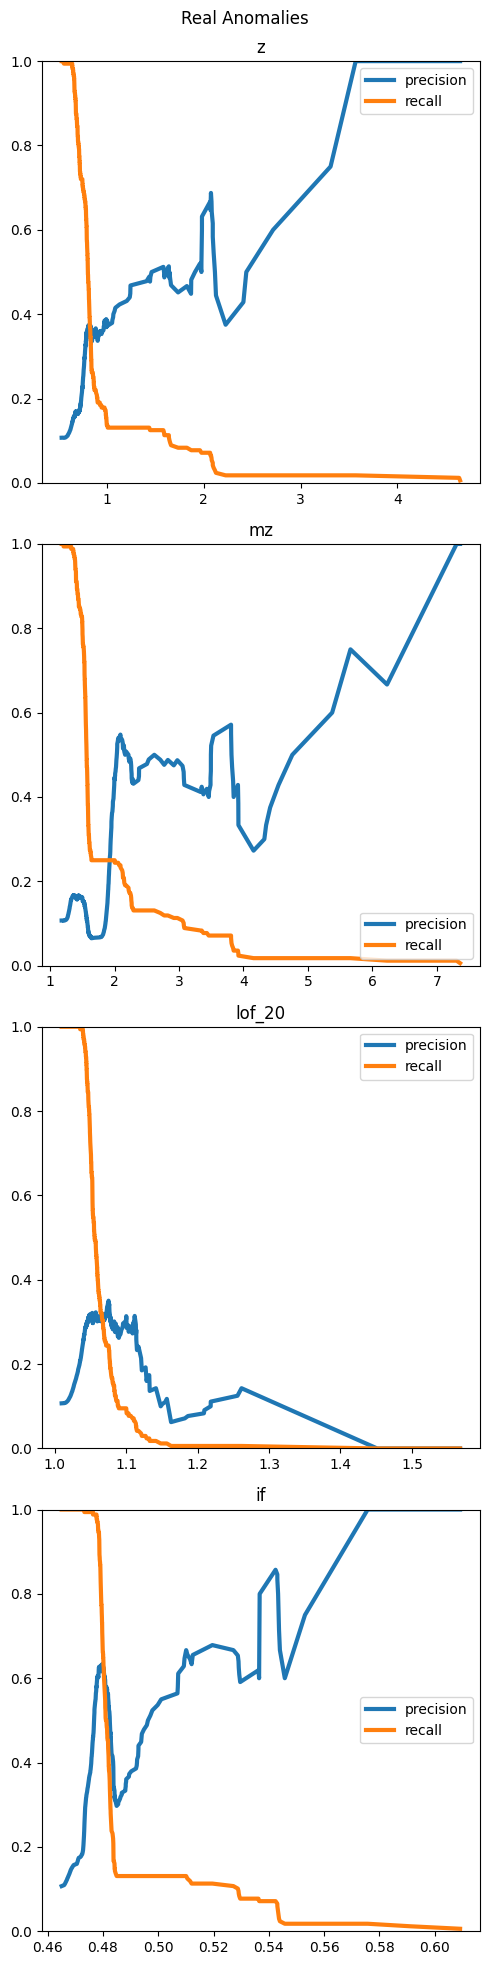

In [28]:
rp_curves = {}
for exp in models:
    mname = exp.name
    rp_curves[mname] = {}
    for (ename, exp) in exps_none.items():
        rp_curves[mname] = exp.results['pr'][mname]
with warnings.catch_warnings(action="ignore"):
    plot_rpcurves(rp_curves, colnums=1, title="Real Anomalies\n", auc=False, f1=False, showtitle=True)